Datacamp LDA example from:

https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=8

LDA yields 2 Dirichlet distributions:
1. Topics per text item (probabilities)
2. Words per topic

Implementation
1. Load the train dataset created in 00_load_data
3. Tokenize. Dictionary: which words appear how often in all of the text, Corpus: for each text line, the count of words that appear.
4. Fit the LDA model on the train data, save it


In [5]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
import tok

%matplotlib inline

In [6]:
%%time

arxiv_nlp = pd.read_csv('../data/arxiv_nlp_train.csv.zip', index_col=0)

CPU times: user 319 ms, sys: 47.8 ms, total: 367 ms
Wall time: 367 ms


In [7]:
arxiv_nlp = arxiv_nlp[:200]

## Tokenize

Apply default pre-processing filters:
strip_tags, strip_punctuation, strip_multiple_whitespaces, stric_numeric, remove_stopwords; strip_short, stem_text

see: https://github.com/piskvorky/gensim/blob/develop/gensim/parsing/preprocessing.py

Reserve 10% of the texts for computing perplexity when fitting the model's k-parameter.

In [8]:
texts = tok.clean(arxiv_nlp['abstract'])
dictionary = tok.make_dictionary(texts)

# use chunk for evaluating perplexity
arxiv_nlp_train, chunk = train_test_split(arxiv_nlp, test_size=0.1)

# tokenize
texts = tok.clean(arxiv_nlp_train['abstract'])
corpus = tok.make_corpus(dictionary, texts)

# tokenize chunk
texts_chunk = tok.clean(chunk['abstract'])
corpus_chunk = tok.make_corpus(dictionary, texts_chunk)

## Fit the LDA model
Fit the model on the training set, for different values of k.

Validate the model by computing perplexity for different values of k. The best value for k is that which yields a perplexity closest to 0.

Since LDA has a random component, the best k might vary between runs. Therefore the model is fitted several times and the best value is compiled from all runs (mode of best k for all runs).

see: https://radimrehurek.com/gensim/models/ldamodel.html

In [11]:
%%time

min_k = 2
max_k = 12
max_runs = 5
perplexity = []
for run in range(max_runs):
    print(f"Run {run + 1} / {max_runs}")
    px = []
    num_topics = []
    for k in range(min_k, max_k + min_k):
        # Define the LDA model
        ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word=dictionary, passes=15)
        num_topics.append(k)
        px.append(ldamodel.log_perplexity(corpus_chunk))
    perplexity.append(pd.DataFrame.from_dict({'k': num_topics, 'val': px}))

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 55.3 s, sys: 7.91 ms, total: 55.3 s
Wall time: 55.3 s


The "log_perplexity" function returns the per-word likelihood _bound_. The _perplexity_ itself can be computed by

$$perplexity = 2^{-bound}$$


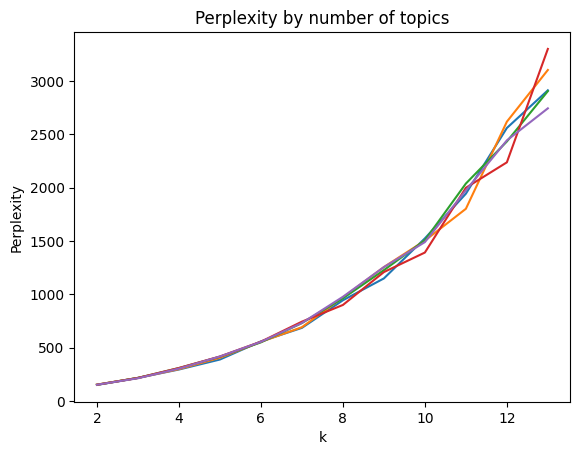

In [12]:
for run in range(max_runs):
    plt.plot(perplexity[run].k, 2**(-perplexity[run].val))
plt.title("Perplexity by number of topics")
plt.xlabel("k")
plt.ylabel("Perplexity")
plt.show()

### Find the best k value: mode of list of best values for each run

In [13]:
import statistics

best_k_runs = []
for run in range(max_runs):
    best_k_runs.append(perplexity[run].sort_values('val', ascending=False).iloc[0]['k'])
best_k = statistics.mode(best_k_runs)
print(f"Best number of topics after {max_runs} runs is: {best_k}")

Best number of topics after 5 runs is: 2.0


## Refit the model, with best k

In [14]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=best_k, id2word=dictionary, passes=15)

Print the topics, with top words

In [15]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.021*"task" + 0.014*"gener" + 0.012*"base" + 0.012*"inform" + 0.012*"knowledg"')
(1, '0.022*"train" + 0.019*"data" + 0.017*"method" + 0.013*"perform" + 0.010*"learn"')


[nltk_data] Downloading package wordnet to /home/atroncos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
wnl.lemmatize('kites babies dogs flying smiling driving died tried feet')

'kites babies dogs flying smiling driving died tried feet'

## Save the model

In [10]:
import pickle

with open('../models/lda_nlp_train.pickle', 'wb') as handle:
    pickle.dump(ldamodel, handle, protocol=pickle.HIGHEST_PROTOCOL)